/tmp/ipykernel_1221699/3022888785.py:76: RuntimeWarning: invalid value encountered in cast
  background = np.divide(background_sum, count, where=count > 0).astype(np.uint8)


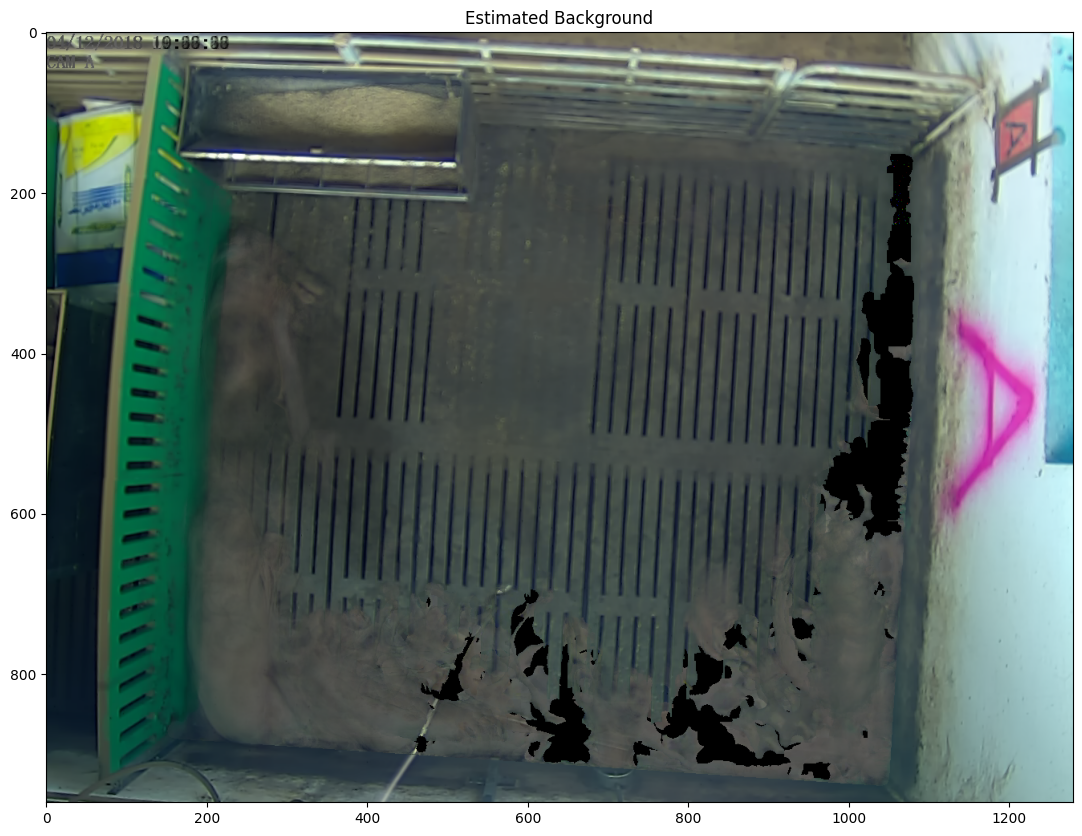

In [4]:
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import skimage

plt.rcParams['figure.figsize'] = (20, 10)

def segment(img):
    """Segment pigs from the image."""
    rr, cc = skimage.draw.polygon([70, 880, 940, 130], [220, 150, 1050, 1100])
    inside_mask = np.zeros(img.shape[:-1], bool)
    inside_mask[rr, cc] = True
    inside_mask[:190, :520] = False
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    h = h / 180.0  # Normalize H channel to match skimage scale (0-1)
    
    mask = inside_mask & ((h < 0.2) | (h > 0.6) | (v > 90))
    
    mask = skimage.morphology.remove_small_holes(mask, 1000)
    mask = skimage.morphology.binary_opening(mask, skimage.morphology.disk(8))
    mask = skimage.morphology.remove_small_objects(mask, 3000)
    
    return mask

def construct_background(video_folder, num_frames=50):
    """Construct the background by averaging frames without detected pigs from all videos."""
    videos = sorted([os.path.join(video_folder, v) for v in os.listdir(video_folder) if v.endswith(('.mp4', '.avi'))])
    if not videos:
        print("No valid video files found in the directory.")
        return None
    
    background_sum = None
    count = None
    total_frames_processed = 0
    
    for video_path in videos:
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        if total_frames <= 0:
            cap.release()
            continue
        
        selected_frames = random.sample(range(total_frames), min(num_frames, total_frames))
        
        for frame_idx in selected_frames:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            if not ret:
                continue
            
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            mask = segment(frame)
            
            img_no_pigs = frame.copy()
            img_no_pigs[mask] = 0  # Remove pig regions
            
            if background_sum is None:
                background_sum = np.zeros_like(img_no_pigs, dtype=np.float32)
                count = np.zeros_like(img_no_pigs, dtype=np.int32)
            
            background_sum += img_no_pigs
            count += (~mask)[..., np.newaxis].astype(int)
            total_frames_processed += 1
        
        cap.release()
    
    if background_sum is None or total_frames_processed == 0:
        print("No frames processed.")
        return None
    
    background = np.divide(background_sum, count, where=count > 0).astype(np.uint8)
    return background

# Example usage
path = '/data/bioeng/pigs/videosPenA_2018_12_04_9h04_12h14'
background = construct_background(path, 100)

if background is not None:
    plt.imshow(background)
    plt.title('Estimated Background')
    plt.show()

In [ ]:
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import skimage

plt.rcParams['figure.figsize'] = (20, 10)

def segment(img):
    """Segment pigs from the image."""
    rr, cc = skimage.draw.polygon([70, 880, 940, 130], [220, 150, 1050, 1100])
    inside_mask = np.zeros(img.shape[:-1], bool)
    inside_mask[rr, cc] = True
    inside_mask[:190, :520] = False
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    h = h / 180.0  # Normalize H channel to match skimage scale (0-1)
    
    mask = inside_mask & ((h < 0.2) | (h > 0.6) | (v > 90))
    
    mask = skimage.morphology.remove_small_holes(mask, 1000)
    mask = skimage.morphology.binary_opening(mask, skimage.morphology.disk(8))
    mask = skimage.morphology.remove_small_objects(mask, 3000)
    
    return mask

def construct_background_from_images(image_folder, num_images=50):
    """Construct the background by averaging frames without detected pigs from images in the folder."""
    images = sorted([os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith(('.png', '.jpg'))])
    
    if not images:
        print("No valid images found in the directory.")
        return None
    
    selected_images = random.sample(images, min(num_images, len(images)))
    background_sum = None
    count = None
    total_images_processed = 0
    
    for img_path in selected_images:
        img = cv2.imread(img_path)
        if img is None:
            continue
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = segment(img)

        img_no_pigs = img.copy()
        img_no_pigs[mask] = 0  # Remove pig regions
        
        if background_sum is None:
            background_sum = np.zeros_like(img_no_pigs, dtype=np.float32)
            count = np.zeros_like(img_no_pigs, dtype=np.int32)
        
        background_sum += img_no_pigs
        count += (~mask)[..., np.newaxis].astype(int)
        total_images_processed += 1
    
    if background_sum is None or total_images_processed == 0:
        print("No images processed.")
        return None
    
    background = np.divide(background_sum, count, where=count > 0).astype(np.uint8)
    return background

# Example usage
extracted_frames_folder = "./extracted_frames"  # Path where extracted frames are stored
background = construct_background_from_images(extracted_frames_folder, 100)

if background is not None:
    plt.imshow(background)
    plt.title('Estimated Background')
    plt.show()
